In [1]:
# This is the script for filtering tracks that are in vicinity of China Mainland (< X degree of coastline).
# Input file: CMA best track -- CMA_Best_Tracks_Nodes.shp,  
#             China border shape file -- '/home/lzhou/GIS/China_Border/CHN_adm0.shp'
# Output Dir: /home/lzhou/Precipitation/Precipitation_Scripts/Output
# Outfile: CMA_500km_tracks.shp

In [2]:
import os
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point, Polygon
import geopandas as gpd
from pyproj import CRS
import seaborn as sns
import matplotlib.pyplot as plt

# Make some of the spatial queries running faster
from shapely import speedups
import shapely
speedups.enabled

True

In [3]:
# load the best track shape file
zone=10 #degree around tracks
indir = '/home/lzhou/Precipitation/Precipitation_Scripts/Output/'
#indir = r'D:\GitHub\Precipitation_Scripts\Output'
nodes = gpd.read_file(os.path.join(indir,'CMA_Best_Tracks_Nodes.shp'))
tracks = gpd.read_file(os.path.join(indir,'CMA_Best_Tracks.shp'))

In [4]:
# get China shape file
#shapefile = '/home/lzhou/GIS/china-shapefiles-master/ne_10m_coastline.shp'
#shapefile = '/home/lzhou/GIS/China_Border/CHN_adm0.shp'
#cn_shape = gpd.read_file(shapefile)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cn_shape = world[world.name=='China'].copy()
cn_shape.reset_index(drop=True,inplace=True)
tw_shape = world[world.name=='Taiwan'].copy()
tw_shape.reset_index(drop=True,inplace=True)
greater_cn = cn_shape.geometry.union(tw_shape['geometry'])

<AxesSubplot:>

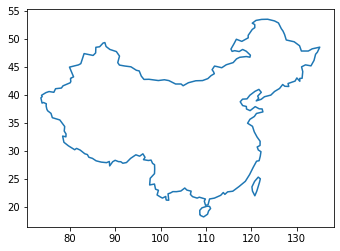

In [5]:
greater_cn.boundary.plot()

In [6]:
# filter out nodes that are on land
test1 = nodes.geometry.apply(lambda x: x.within(greater_cn.iloc[0]))
nodes_onland = nodes[test1].copy()
nodes_onland.to_file(os.path.join(indir,'CMA_Tracks_Nodes_on_Land.shp'))


In [7]:
# filter out tracks that are on land
test0 = tracks.geometry.apply(lambda x: x.intersects(greater_cn.iloc[0]))
tracks_onland = tracks[test0].copy()
tracks_onland.to_file(os.path.join(indir,'CMA_Tracks_on_Land.shp'))

<AxesSubplot:>

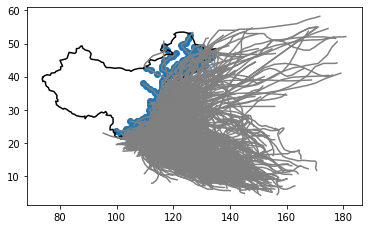

In [8]:
#plot to check
m=nodes_onland.plot()
cn_shape.boundary.plot(ax=m,color='black')
tracks_onland.plot(ax=m,color='grey')
#buffer.boundary.plot(ax=m,color='red')


/tmp/ipykernel_18149/582217054.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = envelope.buffer(zone)


<AxesSubplot:>

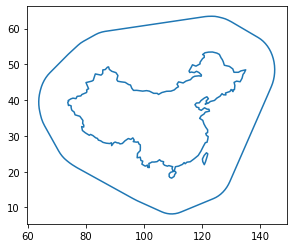

In [9]:
# since buffering cn_shape takes forever, get a envelope around the shape for approximation
envelope = greater_cn.geometry.convex_hull
buffer = envelope.buffer(zone)
ax=buffer.boundary.plot()
greater_cn.boundary.plot(ax=ax)

In [10]:
#plot to check
#test0 = tracks.geometry.apply(lambda x: x.intersects(cn_shape.loc[0,'geometry']))
test2 = tracks.geometry.apply(lambda x: x.intersects(buffer.loc[0]))
tracks_500km = tracks[test2].copy()

test3 = nodes.geometry.apply(lambda x: x.within(buffer.loc[0]))
nodes_500km = nodes[test3].copy()

In [11]:
len(tracks_500km.CNID.unique())

1165

<AxesSubplot:>

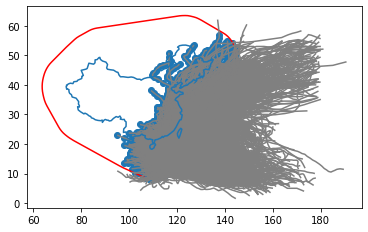

In [12]:
m=nodes_500km.plot()
buffer.boundary.plot(ax=m,color='red')
tracks_500km.plot(ax=m,color='grey')
greater_cn.boundary.plot(ax=m)

In [13]:
# save the filtered nodes and results
tracks_500km.reset_index(drop=True,inplace=True)
nodes_500km.reset_index(drop=True,inplace=True)
tfile = 'CMA_Tracks_'+str(zone)+'degree.shp'
nfile = 'CMA_Tracks_Nodes_' + str(zone)+'degree.shp'
tracks_500km.to_file(os.path.join(indir,tfile))
nodes_500km.to_file(os.path.join(indir,nfile))
